In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import corner
import h5py
import lal
import pystan
import scipy.linalg as sl
import scipy.signal as sig
import scipy.stats as ss
import seaborn as sns
import qnm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

INFO:root:Could not load Schw QNM dict from file /Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/qnm/schwarzschild/data/Schw_dict.pickle


Here are the parameters that we used in [Isi, et al. (2019)](http://dx.doi.org/10.1103/PhysRevLett.123.111102).

In [3]:
ra = 1.95
dec = -1.27
psi = 0.82
cos_iota = -0.999

tgps_H = 1126259462.423

dt_H = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['H1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))
dt_L = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix['L1'].location, ra, dec, lal.LIGOTimeGPS(tgps_H))

tgps_geocent = tgps_H - dt_H
tgps_L = tgps_geocent + dt_L

gmst = lal.GreenwichMeanSiderealTime(lal.LIGOTimeGPS(tgps_H))
FpH, FcH = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['H1'].response, ra, dec, psi, gmst)
FpL, FcL = lal.ComputeDetAMResponse(lal.cached_detector_by_prefix['L1'].response, ra, dec, psi, gmst)

In [4]:
FpH, FcH, FpL, FcL

(0.5787432123814908,
 -0.4509465159486486,
 -0.5274337839186076,
 0.20520844606870395)

In [5]:
with h5py.File('H-H1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Hstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Hts = linspace(T0, T0+32-1.0/4096, Hstrain.shape[0])

with h5py.File('L-L1_LOSC_4_V2-1126259446-32.hdf5', 'r') as f:
    Lstrain = array(f['strain/Strain'])
    T0 = f['meta/GPSstart'][()]
    Lts = linspace(T0, T0+32-1/4096, Lstrain.shape[0])
    
fny = 1.0/(Hts[1]-Hts[0])/2.0

We will butterworth bandpass the data from 20 Hz to 1024 Hz (so a sample rate of 2048 Hz).  That allows us to decimate the data by a factor of two.

In [6]:
iH = np.argmin(np.abs(Hts - tgps_H))
iL = np.argmin(np.abs(Lts - tgps_L))

if Hts[iH] > tgps_H:
    iH -= 1
if Lts[iL] > tgps_L:
    iL -= 1

if iH % 2 == 1:
    print('Rolling H by one sample')
    Hstrain = roll(Hstrain, -1)
    Hts = roll(Hts, -1)
if iL % 2 == 1:
    print('Rolling L by one sample')
    Lstrain = roll(Lstrain, -1)
    Lts = roll(Lts, -1)

fLow = 20.0 # Hz
ds_factor = 2
b, a = sig.butter(4, fLow/fny, btype='highpass', output='ba')
Hfilt = sig.filtfilt(b, a, Hstrain)
Lfilt = sig.filtfilt(b, a, Lstrain)

Hfilt = sig.decimate(Hfilt, ds_factor, zero_phase=True)
Lfilt = sig.decimate(Lfilt, ds_factor, zero_phase=True)

Hfilt = Hfilt - mean(Hfilt)
Lfilt = Lfilt - mean(Lfilt)

Htsfilt = Hts[::ds_factor]
Ltsfilt = Lts[::ds_factor]

# Grab the first sample before merger
I0H = np.argmin(np.abs(Htsfilt - tgps_H))
I0L = np.argmin(np.abs(Ltsfilt - tgps_L))

print('t0_H - tgps_H is {:.5f} s'.format(Htsfilt[I0H]-tgps_H))
print('t0_L - tgps_L is {:.5f} s'.format(Ltsfilt[I0L]-tgps_L))

gamma_min = 100.0
min_decay = 10.0
Nanalyze = int(round(min_decay / (gamma_min*(Htsfilt[1]-Htsfilt[0]))))
Tanalyze = Nanalyze*(Htsfilt[1]-Htsfilt[0])
print('Will analyze {:.3f} s of data'.format(Tanalyze))

t0_H - tgps_H is -0.00015 s
t0_L - tgps_L is 0.00000 s
Will analyze 0.100 s of data


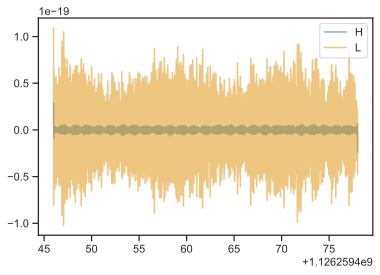

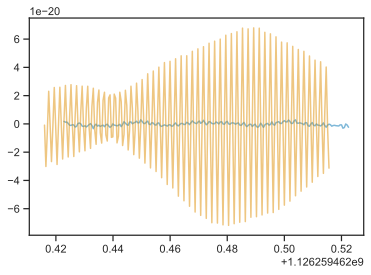

In [7]:
plot(Htsfilt, Hfilt, label='H', alpha=0.5)
plot(Ltsfilt, Lfilt, label='L', alpha=0.5)

legend(loc='best')

figure()
plot(Htsfilt[I0H:I0H+Nanalyze], Hfilt[I0H:I0H+Nanalyze], label='H', alpha=0.5)
plot(Ltsfilt[I0L:I0L+Nanalyze], Lfilt[I0L:I0L+Nanalyze], label='L', alpha=0.5)

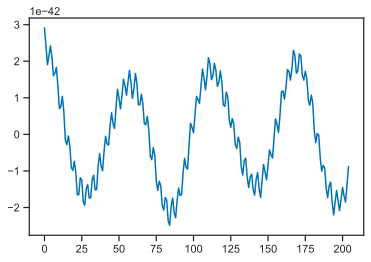

In [31]:
# We want to be sure the filter has warmed up, so trim the first two seconds
Ttrim = 2 # Seconds
Ntrim = Ttrim*4096

Hrho = sig.correlate(Hfilt[Ntrim:-Ntrim], Hfilt[Ntrim:-Ntrim])
Hrho = ifftshift(Hrho)
Hrho = Hrho / len(Hfilt[Ntrim:-Ntrim])
plot(Hrho[:Nanalyze])

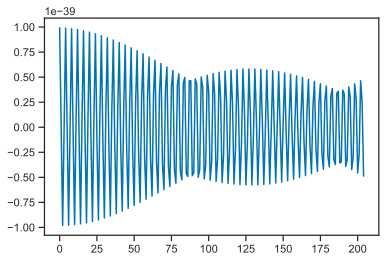

In [32]:
Lrho = sig.correlate(Lfilt[Ntrim:-Ntrim], Lfilt[Ntrim:-Ntrim])
Lrho = ifftshift(Lrho)
Lrho = Lrho / len(Lfilt[Ntrim:-Ntrim])
plot(Lrho[:Nanalyze])

In [34]:
HC = sl.toeplitz(Hrho[:Nanalyze])
HCorr = sl.toeplitz(HC[0,:]/HC[0,0])
HL = np.linalg.cholesky(HC)
HCorrL = np.linalg.cholesky(HCorr)

LC = sl.toeplitz(Lrho[:Nanalyze])
LCorr = sl.toeplitz(LC[0,:]/LC[0,0])
LL = np.linalg.cholesky(LC)
LCorrL = np.linalg.cholesky(LCorr)

This is something like the GW150914 plot: whitened data, with L shifted and inverted.

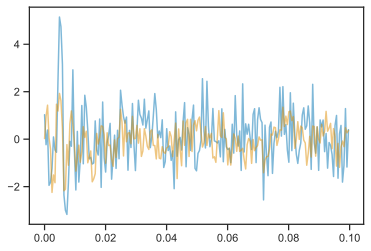

In [35]:
t = (Htsfilt[1]-Htsfilt[0])*arange(Nanalyze)
plot(t, np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), label='H', alpha=0.5)
plot(t, -np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), label='L', alpha=0.5)

In [36]:
x = randn(Nanalyze)
bHc = sl.cho_solve((HL, True), x)
bHt = sl.solve_toeplitz(Hrho[:Nanalyze], x)

In [37]:
x = randn(Nanalyze)
bLc = sl.cho_solve((LL, True), x)
bLt = sl.solve_toeplitz(Lrho[:Nanalyze], x)

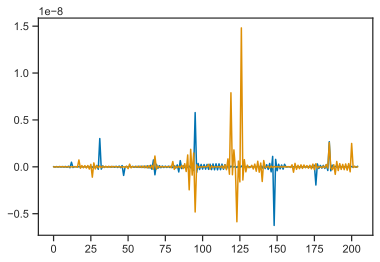

In [38]:
plot(2.0*(bHc-bHt)/(np.abs(bHc) + np.abs(bHt)))
plot(2.0*(bLc-bLt)/(np.abs(bLc) + np.abs(bLt)))

In [39]:
fref = 2.98e3 # Hz, at 68 MSun
chi0 = 0.69

g220 = qnm.modes_cache(-2, 2, 2, 0)
omega, _, _ = g220(a=chi0)
f0 = real(omega)/(2*pi) * fref
gamma0 = abs(imag(omega)) * fref

g221 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g221(a=chi0)
f1 = real(omega)/(2*pi) * fref
gamma1 = abs(imag(omega)) * fref

g222 = qnm.modes_cache(-2, 2, 2, 1)
omega, _, _ = g222(a=chi0)
f2 = real(omega)/(2*pi) * fref
gamma2 = abs(imag(omega)) * fref

print('Given estimated tau0, expect signal to be down by exp(-{:.1f}) by end of data'.format(gamma0*Tanalyze))

Given estimated tau0, expect signal to be down by exp(-24.2) by end of data


In [16]:
model_constrained = pystan.StanModel(file='ringdown_constrained.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb84bbe293d83bdc1ac4e5380837a9b1 NOW.
/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpytbhii37/stanfit4anon_model_eb84bbe293d83bdc1ac4e5380837a9b1_1325216895817941076.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [40]:
data_constrained = {
    'nobs': 2,
    'nsamp': Nanalyze,
    
    't0': [tgps_H, tgps_L],
    'ts': [Htsfilt[I0H:I0H+Nanalyze], Ltsfilt[I0L:I0L+Nanalyze]],
    'strain': [Hfilt[I0H:I0H+Nanalyze], Lfilt[I0L:I0L+Nanalyze]],
    'L': [HL, LL],
    
    'mu_logf': log(f0),
    'sigma_logf': 0.5,
    
    'mu_loggamma': log(gamma0),
    'sigma_loggamma': 0.5,
    
    'FpFc': [[FpH, FcH], [FpL, FcL]],
    'cos_inc': cos_iota,
    
    'Amax': 1e-19,
    
    'df_dg_max': 1e-3 # No deviation from GR.
}

In [41]:
fit_constrained = model_constrained.sampling(data=data_constrained)
fit_constrained = az.convert_to_inference_data(fit_constrained)

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [42]:
data_modgr = data_constrained.copy()
data_modgr['df_dg_max'] = 0.5

In [43]:
fit_modgr = model_constrained.sampling(data=data_modgr)
fit_modgr = az.convert_to_inference_data(fit_modgr)

In [53]:
az.to_netcdf(fit_constrained, 'GW150914_GR.nc')
az.to_netcdf(fit_modgr, 'GW150914.nc')

'GW150914.nc'

In [22]:
fit_constrained = az.from_netcdf('GW150914_GR.nc')
fit_modgr = az.from_netcdf('GW150914.nc')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12125dfd0>,
      dtype=object)

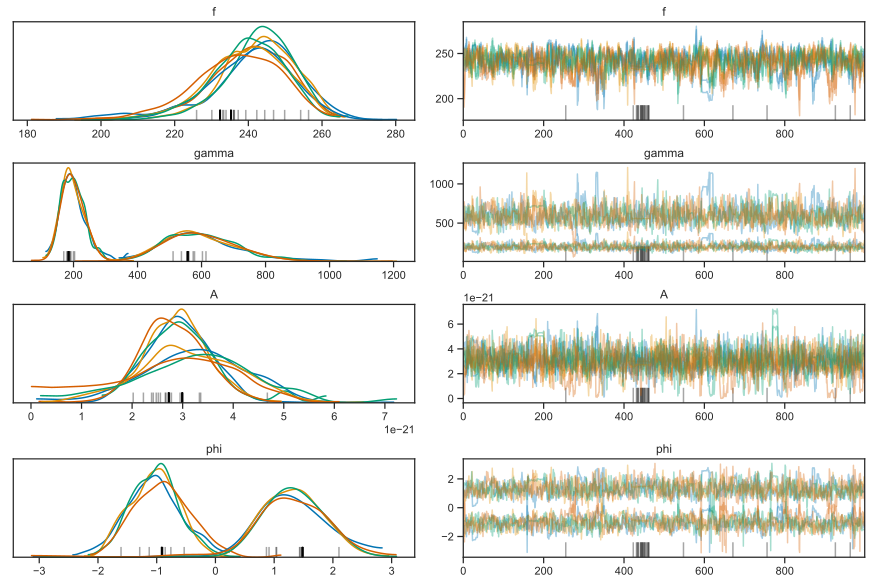

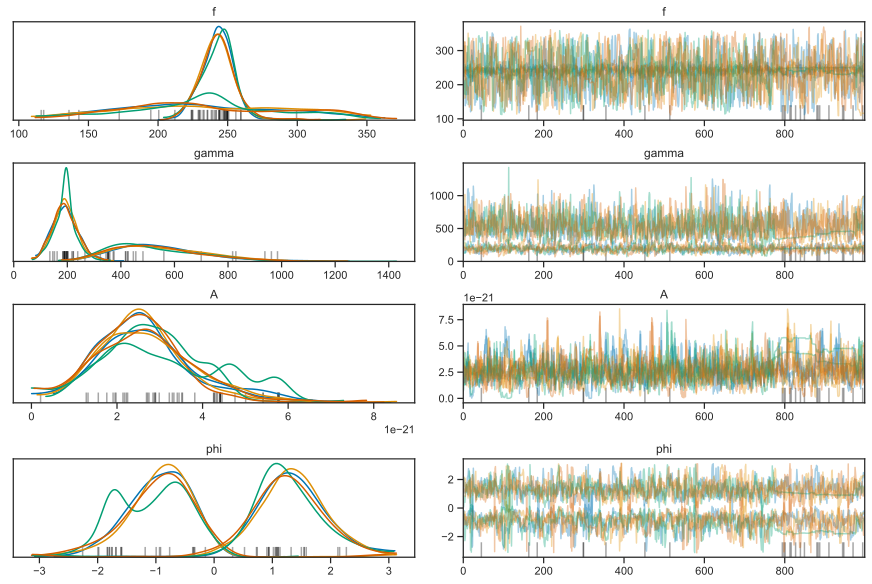

In [44]:
az.plot_trace(fit_constrained,
              var_names=['f', 'gamma', 'A', 'phi'], compact=True)
az.plot_trace(fit_modgr,
              var_names=['f', 'gamma', 'A', 'phi'], compact=True)

A1 = 3.1e-21 +/- 1.1e-21
A1 > 0 at 3 sigma


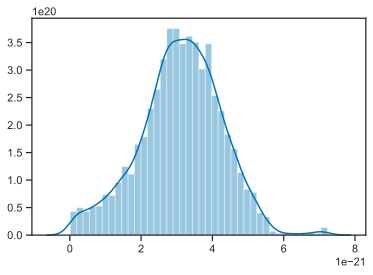

In [45]:
sns.distplot(fit_constrained.posterior.A.values[:,:,1].flatten())
print('A1 = {:.2g} +/- {:.2g}'.format(mean(fit_constrained.posterior.A.values[:,:,1]), std(fit_constrained.posterior.A.values[:,:,1])))
print('A1 > 0 at {:.1g} sigma'.format(mean(fit_constrained.posterior.A.values[:,:,1])/std(fit_constrained.posterior.A.values[:,:,1])))

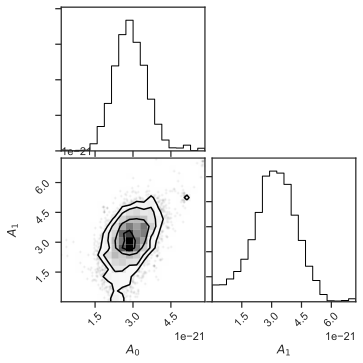

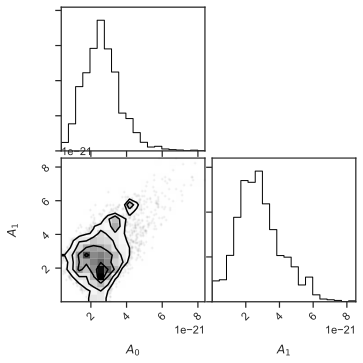

In [46]:
corner.corner(fit_constrained.posterior.A.values.reshape((-1, 2)),
              labels=[r'$A_0$', r'$A_1$']);
corner.corner(fit_modgr.posterior.A.values.reshape((-1, 2)),
              labels=[r'$A_0$', r'$A_1$']);

This should be like the plot in the paper, but is not yet there.

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/arviz/plots/kdeplot.py:384: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(cov ** 0.5)


(<matplotlib.axes._subplots.AxesSubplot at 0x11996fe48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e492630>)

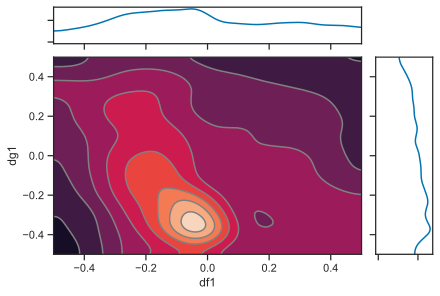

In [47]:
az.plot_joint(fit_modgr, var_names=['df1', 'dg1'], kind='kde')

Here is the signal in the two detectors:

Text(0, 0.5, '$h(t)$')

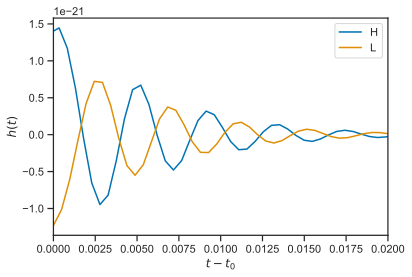

In [48]:
plot(Htsfilt[I0H:I0H+Nanalyze]-tgps_H, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1)), label='H')
plot(Ltsfilt[I0L:I0L+Nanalyze]-tgps_L, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1)), label='L')
legend(loc='best')
axis(xmin=0, xmax=0.02)
xlabel(r'$t-t_0$')
ylabel(r'$h(t)$')

De-correlated:

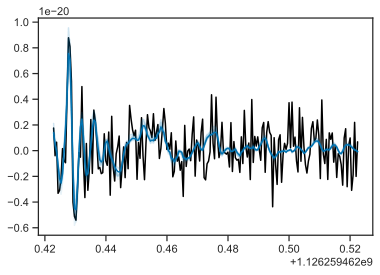

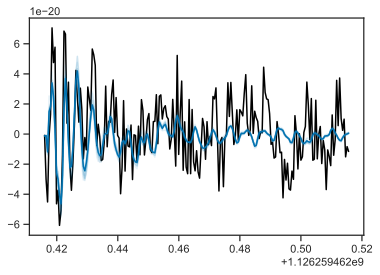

In [49]:
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, Hfilt[I0H:I0H+Nanalyze]), '-k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HCorrL, fit_constrained.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)

figure()

plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, Lfilt[I0L:I0L+Nanalyze]), '-k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LCorrL, fit_constrained.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)

Whitened:

(1126259462.4160156,
 1126259462.4404297,
 -3.2360838586199456,
 3.549348451425169)

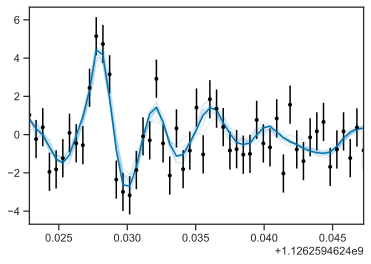

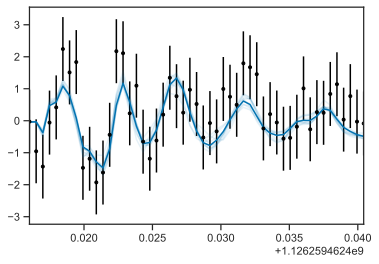

In [50]:
Nplot = 50
errorbar(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, Hfilt[I0H:I0H+Nanalyze]), yerr=ones(Nanalyze), fmt='.', color='k')
plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, mean(fit_constrained.posterior.h_det.values[:,:,0,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Htsfilt[I0H:I0H+Nanalyze], np.linalg.solve(HL, fit_constrained.posterior.h_det.values[k,l,0,:]), color=sns.color_palette()[0], alpha=0.1)
axis(xmin=Htsfilt[I0H], xmax=Htsfilt[I0H+Nplot])    
    
figure()

errorbar(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, Lfilt[I0L:I0L+Nanalyze]), yerr=ones(Nanalyze), fmt='.', color='k')
plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, mean(fit_constrained.posterior.h_det.values[:,:,1,:], axis=(0,1))))
for i in range(10):
    nc, ns = fit_constrained.posterior.h_det.values.shape[:2]
    k = randint(nc)
    l = randint(ns)
    plot(Ltsfilt[I0L:I0L+Nanalyze], np.linalg.solve(LL, fit_constrained.posterior.h_det.values[k,l,1,:]), color=sns.color_palette()[0], alpha=0.1)
axis(xmin=Ltsfilt[I0L], xmax=Ltsfilt[I0L+Nplot])

Whitened residuals and their ACF; vertical line in the ACF indicates a reasonable guess at fundamental frequency.

(0, 0.0244140625, -0.22608503720216683, 1.0583850017715317)

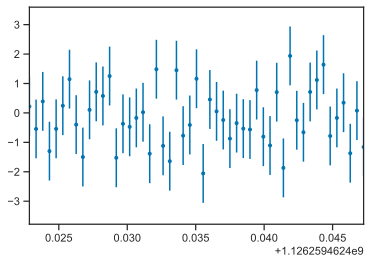

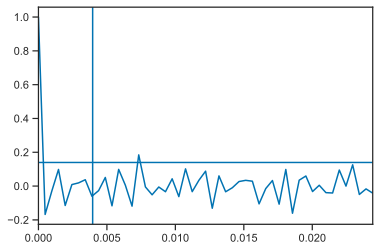

In [51]:
rH = Hfilt[I0H:I0H+Nanalyze] - fit_constrained.posterior.h_det.values[:,:,0,:]
wrH = np.linalg.solve(HL, mean(rH, axis=(0,1)))

errorbar(Htsfilt[I0H:I0H+Nanalyze], wrH, yerr=ones(Nanalyze), fmt='.')
axis(xmin=Htsfilt[I0H], xmax=Htsfilt[I0H+Nplot])    

figure()

acf = sig.correlate(wrH, wrH)
acf = ifftshift(acf)
acf /= acf[0]
acf = acf[:len(wrH)]

plot((Htsfilt[1]-Htsfilt[0])*arange(len(acf)), acf)
axhline(2/sqrt(len(acf)))
axvline(1/(fref*real(g220(0.7)[0]/(2*pi))))
axis(xmin=0, xmax=Nplot*(Htsfilt[1]-Htsfilt[0]))

There is some pesky power left over at the fundamental frequency in L1 that *just will not go away*.  There must be a bug somewhere, but I can't figure where.

(0, 0.0244140625, -0.18403738817124, 1.056382732770059)

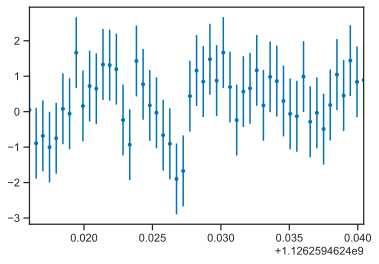

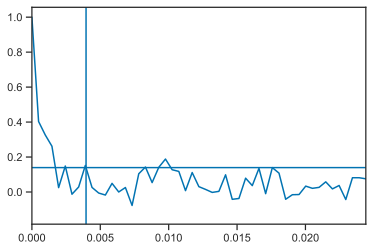

In [52]:
rL = Lfilt[I0L:I0L+Nanalyze] - 2*fit_constrained.posterior.h_det.values[:,:,1,:]
wrL = np.linalg.solve(LL, mean(rL, axis=(0,1)))

errorbar(Ltsfilt[I0L:I0L+Nanalyze], wrL, yerr=ones(Nanalyze), fmt='.')
axis(xmin=Ltsfilt[I0L], xmax=Ltsfilt[I0L+Nplot])
figure()

acf = sig.correlate(wrL, wrL)
acf = ifftshift(acf)
acf /= acf[0]
acf = acf[:len(wrL)]

plot((Ltsfilt[1]-Ltsfilt[0])*arange(len(acf)), acf)
axhline(2/sqrt(len(acf)))
axvline(1/(fref*real(g220(0.7)[0]/(2*pi))))
axis(xmin=0, xmax=Nplot*(Ltsfilt[1]-Ltsfilt[0]))

## Computing Fitting Formulae for Kerr Ringdown Modes

It is a bit un-satisfying to have to find the modes independently; let's instead compute some fitting formluae for the behaviour of the freq and damping rate so we can encode this in Stan.

In [29]:
chis = linspace(0, 1, 100)[1:-1]

In [30]:
freqs0 = array([fref*real(g220(c)[0])/(2*pi) for c in chis])
freqs1 = array([fref*real(g221(c)[0])/(2*pi) for c in chis])

gams0 = array([fref*abs(imag(g220(c)[0])) for c in chis])
gams1 = array([fref*abs(imag(g221(c)[0])) for c in chis])

In [31]:
x = log(freqs0/gams0)

In [32]:
M = column_stack((ones_like(x), x, x*x, x*x*x, x*x*x*x))
coeff_freq = np.linalg.lstsq(M, freqs1/freqs0)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


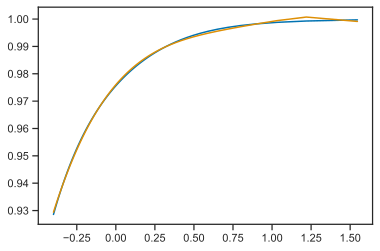

In [33]:
plot(x, freqs1/freqs0)
plot(x, np.dot(M, coeff_freq))

In [34]:
coeff_gam = np.linalg.lstsq(M, gams1/gams0)[0]

/Users/wfarr/anaconda3/envs/ringdown/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


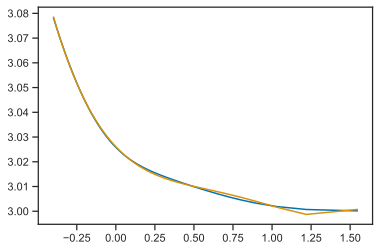

In [35]:
plot(x, gams1/gams0)
plot(x, np.dot(M, coeff_gam))

In [36]:
coeff_freq, coeff_gam

(array([ 0.97598764,  0.06695086, -0.09355756,  0.06990699, -0.02013998]),
 array([ 3.02608227, -0.06722567,  0.11394527, -0.10399184,  0.03334442]))

## Comparisons With [Carullo, Del Pozzo, & Veitch (2019)](http://dx.doi.org/10.1103/PhysRevD.99.123029)

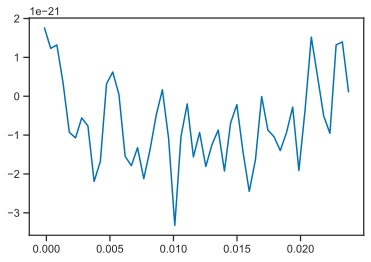

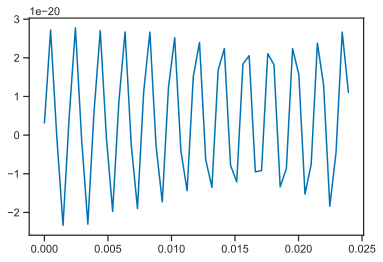

In [52]:
N = 50
plot(Htsfilt[I0H:I0H+N] - tgps_H, Hfilt[I0H:I0H+N])

figure()
plot(Ltsfilt[I0L:I0L+N] - tgps_L, Lfilt[I0H:I0H+N])